In [7]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize
import evaluate
import os

RUN_NAME = "../flan_t5_large_peft_non_preprocess"
OUTPUT_PATH = os.path.join(RUN_NAME, "prediction_with_metrics.csv")
data = pd.read_csv(RUN_NAME + "/prediction.csv")

In [11]:
sns.set_style("darkgrid")
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
plt.rcParams["figure.figsize"] = (10,6)

In [2]:
# data['prediction'] = data['Text']
rouge = evaluate.load('rouge')

In [3]:
data["rouge1"] = -1
data['rouge2'] = -1
data['rougeL'] = -1
data['rougeLsum'] = -1

for idx, row in data.iterrows():
    pred = ["\n".join(sent_tokenize(row['prediction'].strip()))]
    summary = ["\n".join(sent_tokenize(row['Summary'].strip()))]
    result = rouge.compute(predictions=pred, references=summary)
    data.loc[idx, "rouge1"] = result['rouge1']
    data.loc[idx, "rouge2"] = result['rouge2']
    data.loc[idx, "rougeL"] = result['rougeL']
    data.loc[idx, "rougeLsum"] = result['rougeLsum']

In [52]:
data.to_csv(OUTPUT_PATH, index = False)

In [40]:
data = pd.read_csv(OUTPUT_PATH)

In [4]:
data.head()

,Customer,Type,Text,Summary,sim_score,split,prediction,rouge1,rouge2,rougeL,rougeLsum
0,figma,Twitter,User: RT @hellojobkroon: Day 5 of #100DaysOfCo...,User reports that Figma is exporting their fa...,0.054997,test,User is excited about the new Figma features i...,0.166667,0.000000,0.111111,0.111111
1,Notion,Appstore/Playstore,User: application opens but no action is taken...,User is unable to open the application and tab...,0.875306,test,User experiences issues with the application o...,0.521739,0.190476,0.521739,0.521739
2,Notion,Appstore/Playstore,"User: After using the assistant on my laptop, ...",User is disappointed with the Notion app for i...,0.696236,test,User is disappointed with the Notion app on th...,0.369231,0.285714,0.369231,0.369231
3,figma,G2,"User: Before starting each project, I meet wit...",Users appreciate Figma's remote collaboration ...,0.460785,test,User appreciates Miro for its ease of use and ...,0.035088,0.000000,0.035088,0.035088
4,figma,Twitter,User: Teachers🍎📚 We have lots of @DonorsChoose...,User's Pixel Art in Figma blog post is the mos...,0.407185,test,User is excited about the new Figma for Educat...,0.250000,0.043478,0.208333,0.208333


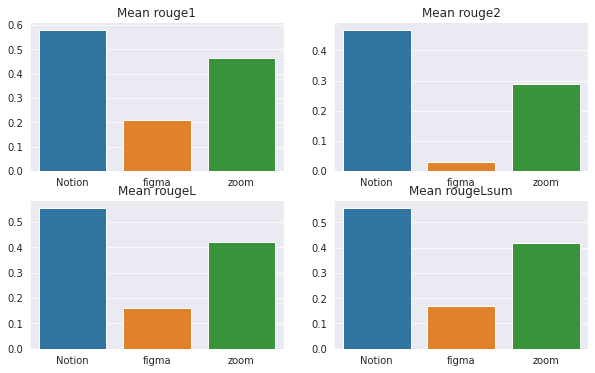

In [41]:
# model is underperforming on figma
all_metrics = ['rouge1', 'rouge2', 'rougeL', 'rougeLsum']
fig, axs = plt.subplots(2, 2)
ax_flatten = axs.flatten()
for i, metric in enumerate(all_metrics):
    mean = data.groupby("Customer")[metric].mean()
    sns.barplot(x = list(mean.index), y = list(mean.values), ax = ax_flatten[i])
    ax_flatten[i].set_title(f"Mean {metric}")

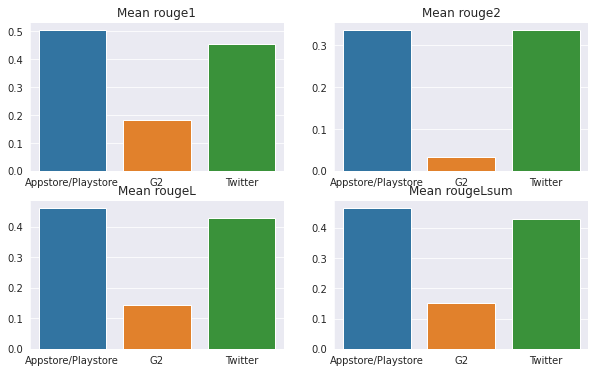

In [42]:
# model is underperforming on G2. 
all_metrics = ['rouge1', 'rouge2', 'rougeL', 'rougeLsum']
fig, axs = plt.subplots(2, 2)
ax_flatten = axs.flatten()
for i, metric in enumerate(all_metrics):
    mean = data.groupby("Type")[metric].mean()
    sns.barplot(x = list(mean.index), y = list(mean.values), ax = ax_flatten[i])
    ax_flatten[i].set_title(f"Mean {metric}")
    

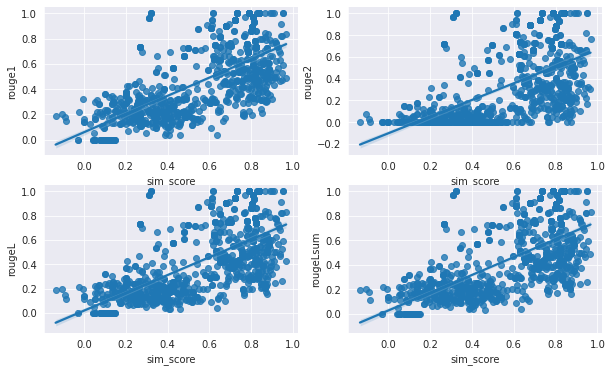

In [43]:
# we see there is a positive correlation between Text-Summary sim score and metric score. Need to look into low simscore pairs and see if there is any mismatch or unrelated Summary.
all_metrics = ['rouge1', 'rouge2', 'rougeL', 'rougeLsum']
fig, axs = plt.subplots(2, 2)
ax_flatten = axs.flatten()
for i, metric in enumerate(all_metrics):
    sns.regplot(x = "sim_score", y = metric, data = data, ax = ax_flatten[i])


Text(0.5, 1.0, 'Mean Rouge over Test set')

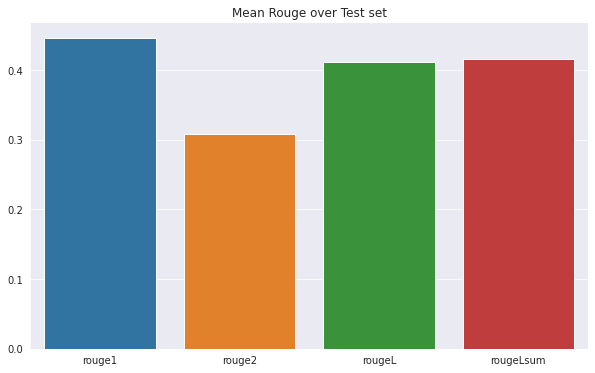

In [44]:
all_mean = data[all_metrics].mean()
sns.barplot(x = list(all_mean.index), y = list(all_mean.values))
plt.title("Mean Rouge over Test set")

In [45]:
data[all_metrics].mean()

rouge1       0.445779
rouge2       0.308819
rougeL       0.412280
rougeLsum    0.416557
dtype: float64

In [46]:
mean = data.groupby(["Type", "Customer"])["rouge1"].mean()
print(mean)

Type                Customer
Appstore/Playstore  Notion      0.510530
                    zoom        0.464661
G2                  figma       0.184096
Twitter             Notion      0.637285
                    figma       0.215157
Name: rouge1, dtype: float64


In [47]:
# lets look at some G2 samples with low score
g2_data = data[(data['Type'] == "G2") & (data['rougeL'] < 0.1)]
counter = 0
for idx, row in g2_data.iterrows():
    print("\n\nText:\n", row['Text'])
    print("\nGT:\n", row['Summary'])
    print("\nPrediction:\n", row['prediction'])
    counter += 1
    if counter > 5:
        break

# the predictions look much better than the GT. Sometimes the predictions are incomplete and end abruptly



Text:
 User: Before starting each project, I meet with my clients to know what they want. To do this, we connect through Miro and create a dashboard to facilitate these explanations so that what is most important is recorded. 
The result of this session is what I use as a basis for the approach of the project in question virtual office.
User: Miro's navigation was the reason why I decided to use it. It is so good that anyone can adapt to the software with a couple of simple directions. 
I love that the templates can be modified with a few clicks to suit the moment's needs. 
And their visuals are lovely, complete and easy to understand.
User: Miro has no fundamental weaknesses. It is software that does what it is supposed to do. If it is necessary to use other apps, it is because Miro is not designed for it.

GT:
 Users appreciate Figma's remote collaboration capabilities, Jira card integration, canvas design, and various features such as templates, app integrations, presentation tool

In [48]:
from sentence_transformers import SentenceTransformer, util

model_for_embeddings = "all-MiniLM-L6-v2"
model = SentenceTransformer(model_for_embeddings)

def get_sim_score(row):
    #Compute embedding for both lists
    embeddings1 = model.encode(row["Text"], convert_to_tensor=True)
    embeddings2 = model.encode(row["Summary"], convert_to_tensor=True)
    embeddings3 = model.encode(row["prediction"], convert_to_tensor=True)
    #Compute cosine-similarities
    cosine_score_text_pred = util.cos_sim(embeddings1, embeddings3)
    cosine_score_gt_pred = util.cos_sim(embeddings2, embeddings3)
    row['sim_score_text_pred'] = cosine_score_text_pred.item()
    row['sim_score_gt_pred'] = cosine_score_gt_pred.item()
    return row

In [49]:
data = data.apply(get_sim_score, axis = 1)

In [50]:
import wandb

run = wandb.init(project="FeedbackSummarizer")
my_table = wandb.Table(dataframe = data)
run.log({"Test Predictions using Peft Flan-T5-Large Model": my_table})   

In [53]:
data.head()

,Customer,Type,Text,Summary,sim_score,split,prediction,rouge1,rouge2,rougeL,rougeLsum,sim_score_text_pred,sim_score_gt_pred
0,figma,Twitter,User: RT @hellojobkroon: Day 5 of #100DaysOfCo...,User reports that Figma is exporting their fa...,0.054997,test,User is excited about the new Figma features i...,0.166667,0.000000,0.111111,0.111111,0.261967,0.404746
1,Notion,Appstore/Playstore,User: application opens but no action is taken...,User is unable to open the application and tab...,0.875306,test,User experiences issues with the application o...,0.521739,0.190476,0.521739,0.521739,0.779255,0.766034
2,Notion,Appstore/Playstore,"User: After using the assistant on my laptop, ...",User is disappointed with the Notion app for i...,0.696236,test,User is disappointed with the Notion app on th...,0.369231,0.285714,0.369231,0.369231,0.552402,0.835056
3,figma,G2,"User: Before starting each project, I meet wit...",Users appreciate Figma's remote collaboration ...,0.460785,test,User appreciates Miro for its ease of use and ...,0.035088,0.000000,0.035088,0.035088,0.787728,0.439609
4,figma,Twitter,User: Teachers🍎📚 We have lots of @DonorsChoose...,User's Pixel Art in Figma blog post is the mos...,0.407185,test,User is excited about the new Figma for Educat...,0.250000,0.043478,0.208333,0.208333,0.535186,0.568718


In [ ]:
data.to_csv(OUTPUT_PATH, index = False)